===== MovieLens Recommender (Content-based + SVD + Hybrid) =====
Please upload 'ml-latest-small.zip' from your device via the file dialog...


Saving ml-latest-small.zip to ml-latest-small (15).zip
Extracted to ./ml-latest-small/
Loaded Movies: (9742, 3), Ratings: (100836, 4), Tags: (3683, 4)


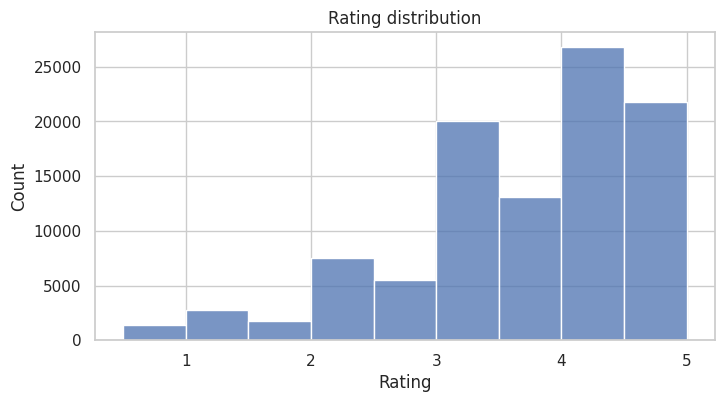


Building TF-IDF (content) components...
TF-IDF built. Saving artifacts...

Sample content-based recommendation for 'Toy Story':
 movieId                                          title
    2355                           Bug's Life, A (1998)
    3114                             Toy Story 2 (1999)
  122918               Guardians of the Galaxy 2 (2017)
    2294                                    Antz (1998)
    3754 Adventures of Rocky and Bullwinkle, The (2000)
    4016               Emperor's New Groove, The (2000)
    4886                          Monsters, Inc. (2001)
   45074                               Wild, The (2006)
   53121                         Shrek the Third (2007)
   65577                 Tale of Despereaux, The (2008)

Training SVD (collaborative) with cross-validation...
Running cross-validation (this may take a few minutes)...


In [ ]:
# Run this first in Colab or terminal
!pip install pandas numpy scikit-learn surprise matplotlib seaborn




#!/usr/bin/env python3
"""
movie_recommender_colab.py
Single-file MovieLens recommender pipeline (Content-based + SVD + Hybrid).
Designed for Google Colab but can run locally (if packages installed).

Save as movie_recommender_colab.py and run in Colab or local Python env.

If running in Colab: If imports fail due to numpy/surprise mismatch, the script
will attempt to install compatible packages and then exit. After install,
restart the runtime and re-run the script.
"""

import sys
import os
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# Ensure dependencies (try import, else install)
# -------------------------
def ensure_packages():
    try:
        import pandas as pd
        import numpy as np
        import sklearn
        import joblib
        import matplotlib
        import seaborn
        import surprise
        return True
    except Exception as e:
        print("Some required packages are missing or incompatible:", str(e))
        print("Attempting to install compatible packages (numpy<2, scikit-surprise, and others).")
        import subprocess
        pkgs = [
            "numpy<2", # Install a compatible version of numpy first
            "pandas",
            "scikit-learn",
            "scipy",
            "matplotlib",
            "seaborn",
            "joblib",
            "scikit-surprise"
        ]
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs])
            print("\nInstallation attempted. IMPORTANT: If you are running in Google Colab, please do: Runtime -> Restart runtime, then re-run this script. Exiting now.")
            return False
        except Exception as ex:
            print("Automatic install failed. Please run manually:")
            print("pip install " + " ".join(pkgs))
            return False

if not ensure_packages():
    sys.exit(0)

# Now safe to import
import zipfile
import io
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import joblib

from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

# -------------------------
# Helper: Upload/extract dataset
# -------------------------
def upload_and_extract_colab():
    """Try to use google.colab.files.upload(); return path base folder"""
    try:
        from google.colab import files
    except Exception:
        return None
    print("Please upload 'ml-latest-small.zip' from your device via the file dialog...")
    uploaded = files.upload()
    zip_filename = None
    for fn in uploaded.keys():
        if fn.endswith('.zip'):
            zip_filename = fn
            break
    if zip_filename is None:
        raise ValueError("No .zip file uploaded. Please upload ml-latest-small.zip")
    extract_folder = 'ml-latest-small'
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print(f"Extracted to ./{extract_folder}/")
    return extract_folder

def extract_local_zip(path_to_zip, extract_folder='ml-latest-small'):
    if not os.path.exists(path_to_zip):
        raise FileNotFoundError(f"{path_to_zip} not found")
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    return extract_folder

def load_movielens(base_folder='ml-latest-small'):
    """
    Robust load: tries common nested layouts.
    Returns: movies, ratings, tags (pandas DataFrames)
    """
    # possible paths
    candidates = [
        os.path.join(base_folder, 'movies.csv'),
        os.path.join(base_folder, base_folder, 'movies.csv'), # Added nested path
        os.path.join(base_folder, 'ml-latest-small', 'movies.csv')
    ]
    for movie_path in candidates:
        if os.path.exists(movie_path):
            folder = os.path.dirname(movie_path)
            movies = pd.read_csv(os.path.join(folder, 'movies.csv'))
            ratings = pd.read_csv(os.path.join(folder, 'ratings.csv'))
            tags = pd.read_csv(os.path.join(folder, 'tags.csv'))
            return movies, ratings, tags
    # fallback: direct files in cwd
    raise FileNotFoundError("Could not find movies.csv in expected paths. Ensure the zip contains movies.csv, ratings.csv, tags.csv")

# -------------------------
# Recommender pipeline
# -------------------------
def build_content_components(movies_df, tags_df, max_features=5000):
    """Build TF-IDF vectorizer and cosine similarity"""
    tags_grouped = tags_df.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
    movies = movies_df.merge(tags_grouped, on='movieId', how='left')
    movies['tag'] = movies['tag'].fillna('')
    movies['combined'] = movies['genres'].astype(str).str.replace('|', ' ') + ' ' + movies['tag']
    tfidf = TfidfVectorizer(stop_words='english', max_features=max_features)
    tfidf_matrix = tfidf.fit_transform(movies['combined'])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return movies, tfidf, tfidf_matrix, cosine_sim

def recommend_content_by_title(movies, cosine_sim, title, topk=10):
    matches = movies[movies['title'].str.contains(title, case=False, regex=False)]
    if matches.empty:
        return None
    idx = matches.index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:topk+1]
    movie_indices = [i for i,_ in sim_scores]
    return movies[['movieId','title']].iloc[movie_indices].reset_index(drop=True)

def train_svd(ratings_df, n_factors=50, n_epochs=20, cv=5):
    reader = Reader(rating_scale=(0.5,5.0))
    data = Dataset.load_from_df(ratings_df[['userId','movieId','rating']], reader)
    svd = SVD(n_factors=n_factors, n_epochs=n_epochs, verbose=False)
    print("Running cross-validation (this may take a few minutes)...")
    cv_results = cross_validate(svd, data, measures=['RMSE','MAE'], cv=cv, verbose=True)
    # fit on full trainset
    trainset = data.build_full_trainset()
    svd.fit(trainset)
    return svd, data, cv_results

def get_top_n_for_user(svd_model, movies_df, ratings_df, user_id, n=10):
    movie_ids_all = movies_df['movieId'].unique().tolist()
    rated_by_user = set(ratings_df[ratings_df['userId']==user_id]['movieId'].tolist())
    candidates = [mid for mid in movie_ids_all if mid not in rated_by_user]
    preds = []
    for mid in candidates:
        pred = svd_model.predict(user_id, mid)
        preds.append((mid, pred.est))
    preds.sort(key=lambda x: x[1], reverse=True)
    topk = preds[:n]
    top_df = pd.DataFrame(topk, columns=['movieId','est']).merge(movies_df[['movieId','title']], on='movieId')
    return top_df[['movieId','title','est']]

def precision_at_k(predictions, k=10, threshold=3.5):
    """
    predictions: list of Surprise predictions (usually from model.test(testset))
    returns avg_precision
    """
    from collections import defaultdict
    user_pred = defaultdict(list)
    for pred in predictions:
        user_pred[pred.uid].append(pred)
    precisions = {}
    for uid, user_predictions in user_pred.items():
        user_predictions.sort(key=lambda x: x.est, reverse=True)
        top_k = user_predictions[:k]
        # some Prediction objects have r_ui attribute (original rating), else r_true
        n_rel = sum((getattr(p,'r_ui', getattr(p,'r_true', 0)) >= threshold) for p in top_k)
        precisions[uid] = n_rel / min(k, len(user_predictions)) if len(user_predictions)>0 else 0
    avg_prec = np.mean(list(precisions.values())) if precisions else 0
    return avg_prec

def hybrid_recommend_for_user(svd_model, movies_df, ratings_df, tfidf_matrix, movie_ids_seed=None, user_id=None, topk=10, alpha=0.5):
    """
    Hybrid: alpha * normalized_content + (1-alpha) * normalized_svd_est
    If movie_ids_seed provided -> build content profile from those movies.
    Else if user_id provided -> use user's rated>=4 as seed.
    """
    if movie_ids_seed is None and user_id is not None:
        user_ratings = ratings_df[ratings_df['userId']==user_id]
        movie_ids_seed = user_ratings[user_ratings['rating']>=4.0]['movieId'].tolist()
    # build profile
    profile = None
    if movie_ids_seed:
        idxs = movies_df[movies_df['movieId'].isin(movie_ids_seed)].index.tolist()
        if idxs:
            profile = tfidf_matrix[idxs].sum(axis=0)
    # candidates: movies not rated by user if user provided else all movies
    if user_id is not None:
        rated_by_user = set(ratings_df[ratings_df['userId']==user_id]['movieId'].tolist())
    else:
        rated_by_user = set()
    candidates = [mid for mid in movies_df['movieId'].tolist() if mid not in rated_by_user]
    preds = []
    for mid in candidates:
        est = svd_model.predict(user_id if user_id is not None else 0, mid).est
        if profile is None:
            content_sim = 0.0
        else:
            mv_index = movies_df[movies_df['movieId']==mid].index
            if mv_index.empty:
                content_sim = 0.0
            else:
                mv_vec = tfidf_matrix[mv_index[0]]
                p_arr = np.asarray(profile).ravel()
                try:
                    m_arr = np.asarray(mv_vec.todense()).ravel()
                except:
                    try:
                        m_arr = np.asarray(mv_vec).ravel()
                    except:
                        m_arr = np.zeros_like(p_arr)
                denom = (np.linalg.norm(p_arr)*np.linalg.norm(m_arr))
                content_sim = (p_arr @ m_arr) / denom if denom != 0 else 0.0
        preds.append((mid, est, content_sim))
    # normalize est and content
    arr_est = np.array([p[1] for p in preds]).reshape(-1,1)
    arr_content = np.array([p[2] for p in preds]).reshape(-1,1)
    scaler = MinMaxScaler()
    if len(arr_est)>0:
        norm_est = scaler.fit_transform(arr_est).ravel()
        norm_content = scaler.fit_transform(arr_content).ravel()
    else:
        norm_est = np.array([])
        norm_content = np.array([])
    final_scores = []
    for i, (mid, est, cont) in enumerate(preds):
        score = alpha * norm_content[i] + (1-alpha) * norm_est[i]
        final_scores.append((mid, est, cont, score))
    final_scores.sort(key=lambda x: x[3], reverse=True)
    topk_list = final_scores[:topk]
    top_df = pd.DataFrame(topk_list, columns=['movieId','svd_est','content_sim','hybrid_score']).merge(movies_df[['movieId','title']], on='movieId')
    return top_df[['movieId','title','svd_est','content_sim','hybrid_score']]

# -------------------------
# Main interactive flow
# -------------------------
def main():
    print("===== MovieLens Recommender (Content-based + SVD + Hybrid) =====")
    # Create artifacts folder
    os.makedirs('artifacts', exist_ok=True)

    # Upload or ask for local path
    colab_base = None
    try:
        from google.colab import files  # type: ignore
        # Running in Colab
        colab_base = upload_and_extract_colab()
    except Exception:
        colab_base = None

    if colab_base is None:
        # Not Colab or upload failed: ask user for path to zip
        zip_path = input("Enter path to ml-latest-small.zip (or press ENTER to abort): ").strip()
        if zip_path == "":
            print("No zip path provided. Exiting.")
            return
        extract_local_zip(zip_path, extract_folder='ml-latest-small')
        base_folder = 'ml-latest-small'
    else:
        base_folder = colab_base

    # Load files
    movies_df, ratings_df, tags_df = load_movielens(base_folder)
    print(f"Loaded Movies: {movies_df.shape}, Ratings: {ratings_df.shape}, Tags: {tags_df.shape}")

    # Plot rating distribution
    plt.figure(figsize=(8,4))
    sns.histplot(ratings_df['rating'], bins=9, kde=False)
    plt.title('Rating distribution')
    plt.xlabel('Rating')
    plt.savefig('artifacts/rating_distribution.png', bbox_inches='tight')
    plt.show()

    # Build content components
    print("\nBuilding TF-IDF (content) components...")
    movies_cb, tfidf, tfidf_matrix, cosine_sim = build_content_components(movies_df, tags_df, max_features=5000)
    print("TF-IDF built. Saving artifacts...")
    joblib.dump(tfidf, 'artifacts/tfidf.joblib')
    np.save('artifacts/cosine_sim.npy', cosine_sim)
    movies_cb.to_csv('artifacts/movies.csv', index=False)

    # Content sample
    print("\nSample content-based recommendation for 'Toy Story':")
    sample = recommend_content_by_title(movies_cb, cosine_sim, "Toy Story")
    if sample is None:
        print("No match for 'Toy Story'")
    else:
        print(sample.to_string(index=False))

    # Train SVD and cross-validate
    print("\nTraining SVD (collaborative) with cross-validation...")
    svd_model, data_obj, cv_results = train_svd(ratings_df, n_factors=50, n_epochs=20, cv=5)
    # Save SVD model
    with open('artifacts/svd_model.pkl', 'wb') as f:
        pickle.dump(svd_model, f)
    print("SVD model trained and saved to artifacts/svd_model.pkl")

    # Show CV RMSE/MAE
    test_rmse = cv_results['test_rmse']
    test_mae = cv_results['test_mae']
    print("Cross-validation RMSE per fold:", test_rmse)
    print("Cross-validation MAE per fold:", test_mae)
    print("Mean RMSE: {:.4f}, Mean MAE: {:.4f}".format(np.mean(test_rmse), np.mean(test_mae)))

    # Save CV plot
    plt.figure(figsize=(8,4))
    plt.bar(range(1,len(test_rmse)+1), test_rmse, alpha=0.7, label='RMSE')
    plt.plot(range(1,len(test_rmse)+1), test_mae, marker='o', color='red', label='MAE')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.title('SVD cross-validation (RMSE per fold, MAE overlay)')
    plt.legend()
    plt.savefig('artifacts/cv_rmse_mae.png', bbox_inches='tight')
    plt.show()

    # Precision@K on holdout
    print("\nComputing Precision@10 on a holdout testset...")
    trainset, testset = train_test_split(data_obj, test_size=0.25, random_state=42)
    svd_temp = SVD(n_factors=50, n_epochs=20)
    svd_temp.fit(trainset)
    predictions = svd_temp.test(testset)
    prec10 = precision_at_k(predictions, k=10, threshold=3.5)
    print(f"Precision@10 (threshold=3.5) on holdout testset: {prec10:.4f}")

    # Save artifacts info
    with open('artifacts/info.txt', 'w') as f:
        f.write("MovieLens recommender artifacts:\n")
        f.write("tfidf -> artifacts/tfidf.joblib\n")
        f.write("cosine -> artifacts/cosine_sim.npy\n")
        f.write("movies csv -> artifacts/movies.csv\n")
        f.write("svd model -> artifacts/svd_model.pkl\n")
        f.write("plots -> artifacts/*.png\n")

    # Interactive loop (English)
    print("\n--- Interactive mode ---")
    print("Options: 'title' -> content-based; 'user' -> collaborative; 'hybrid' -> hybrid fusion; 'similar' -> content-similar; 'exit' -> quit.")

    while True:
        choice = input("\nEnter option ('title'/'user'/'hybrid'/'similar'/'exit'): ").strip().lower()
        if choice == 'exit':
            print("Goodbye.")
            break
        elif choice == 'title':
            q = input("Enter movie title (or part of it): ").strip()
            out = recommend_content_by_title(movies_cb, cosine_sim, q, topk=10)
            if out is None:
                print(f"No movie found matching '{q}'.")
            else:
                print("\nContent-based recommendations:")
                print(out.to_string(index=False))
        elif choice == 'user':
            uid_raw = input("Enter numeric user id: ").strip()
            try:
                uid = int(uid_raw)
            except:
                print("Invalid user id (must be integer).")
                continue
            out_df = get_top_n_for_user(svd_model, movies_cb, ratings_df, uid, n=10)
            if out_df.empty:
                print("No recommendations (user may not exist or rated almost all movies).")
            else:
                print(f"\nTop recommendations for user {uid}:")
                print(out_df.to_string(index=False))
        elif choice == 'hybrid':
            mode = input("Type 'user' to use a user id as seed or 'movies' to provide liked movie ids: ").strip().lower()
            alpha_raw = input("Alpha (0.0 to 1.0) for content weight (default 0.5): ").strip()
            try:
                alpha = float(alpha_raw) if alpha_raw != "" else 0.5
                if not (0.0 <= alpha <= 1.0):
                    alpha = 0.5
            except:
                alpha = 0.5
            if mode == 'user':
                uid_raw = input("Enter numeric user id: ").strip()
                try:
                    uid = int(uid_raw)
                except:
                    print("Invalid user id.")
                    continue
                out = hybrid_recommend_for_user(svd_model, movies_cb, ratings_df, tfidf_matrix, movie_ids_seed=None, user_id=uid, topk=10, alpha=alpha)
                if out.empty:
                    print("No hybrid recommendations (user might not exist or rated most movies).")
                else:
                    print(f"\nHybrid recommendations for user {uid} (alpha={alpha}):")
                    print(out.to_string(index=False))
            elif mode == 'movies':
                s = input("Enter liked movie IDs comma-separated (example: 1,32,200): ").strip()
                try:
                    mids = [int(x.strip()) for x in s.split(',') if x.strip()!='']
                except:
                    print("Invalid movie ids.")
                    continue
                out = hybrid_recommend_for_user(svd_model, movies_cb, ratings_df, tfidf_matrix, movie_ids_seed=mids, user_id=None, topk=10, alpha=alpha)
                if out.empty:
                    print("No hybrid recommendations from provided seeds.")
                else:
                    print(f"\nHybrid recommendations seeded by movies {mids} (alpha={alpha}):")
                    print(out.to_string(index=False))
            else:
                print("Invalid hybrid mode. Choose 'user' or 'movies'.")
        elif choice == 'similar':
            q = input("Enter movie title or numeric movieId: ").strip()
            if q.isdigit():
                mid = int(q)
                matches = movies_cb[movies_cb['movieId']==mid]
                if matches.empty:
                    print(f"MovieId {mid} not found.")
                else:
                    sim = list(enumerate(cosine_sim[matches.index[0]]))
                    sim = sorted(sim, key=lambda x: x[1], reverse=True)[1:11]
                    idxs = [i for i,_ in sim]
                    print("\nMovies similar to movieId", mid)
                    print(movies_cb[['movieId','title']].iloc[idxs].to_string(index=False))
            else:
                out = recommend_content_by_title(movies_cb, cosine_sim, q, topk=10)
                if out is None:
                    print(f"No movie matching '{q}'.")
                else:
                    print("\nMovies similar to", q)
                    print(out.to_string(index=False))
        else:
            print("Invalid option. Choose 'title', 'user', 'hybrid', 'similar', or 'exit'.")

if __name__ == "__main__":
    main()